<div align="center">

# IHE Delft

## Transient Groundwater Flow Course

## Chapter 7

prof. dr.ir. T.N.Olsthoorn

toltsthoorn@gmail.com

Feb. 2025

</div>

# Convolution (a smart way of superposition)

Convolution a lot in many fields of engineering, including signal processing, hydraulics and more also in Groundwater hydrology. There is a paper in Groundwater Journal (Olsthoorn, 2008), which should inspire to use it more often. I include it in the exercises.

For systems working with continuous time, convolution takes the impulse response of the system, and for systems in which we work with discrete time steps, like with values on a daily basis, convolution takes the block response. The impulse response is a "hit" on the system of zero duration with a total content of 1 (i.e. extracting 1 m3 of water from a well at $t=0$), while the block response is taking water from the well at a unit rate during the time step, so extracting 1 m3/d starting at $t=0$ and ending at $t=\Delta t$, where $\Delta t$ is the length of the time step we use in our analysis, often 1 day, but  it may also be one week, one year, 10 days or whatever is most convenient.

The block response is obtained from the step response. The step response of the system is the response of the system due to a unit stress that starts at $t=0$ and goes on forever. The drawdown according to Theis or Hantush is such a step response (if $Q=1$). We get the block response by superposing on this step response the negative step response from $t=\Delta t$. Or, in other words, by switching the well on at $t=0$ with $Q=1$ m3/d, and then switching the well off at $t=\Delta t$ (so often after 1 d, depending on the time step length we want to use). Hence, the block response is easily obtained by superposition of the step response from $t=0$ + the negative step response for $t >= \Delta t$.

To get the result of the drawdown of the well at a given time, caused by all its past extraction, we place the block response on that time, but turned backward in time, and multiply this inverted block response with the extraction in the past and sum it. The result will be the drawdown at this time. Hence this is a weighted average of the past extraction, where the weight is the time-inverted block response. Convolution is just moving this average to the next time and so on. Convolution is thus a moving weighted average of the past extraction, using the block response as weight. This convolution is thus a smart way of superposition. It can be done with the function `lfilter` form the module `Scipy.signal`.

Just realize that most of the analytical transient groundwater solutions are, in fact, step responses. For instance, the impact (drawdown, discharge) caused by a well that starts extracting at a fixed rate from $t=0$, or a surface water of which the water level rises at $t=0$ with a fixed amount and keeps that level forever. The analytical solution describing the effects are step responses.

A step response may also be obtained from a numerical model. For instance a Modflow model in which a well starts extracting at a fixed rate, causes the head and the discharge to change everywhere in the model. The changes over time at ant model cell, are in fact step responses. Hence, a numerical model can provide step responses for any cell in the model at a single run as the head or discharge change caused by the continuous extraction at a fixed rate in any cell of the model starting at a given time.

The block response is obtained from the step response. It's the effect of pumping at a unit rate over the length of one time step or the effect of a sudden head change during one time step. Therefore once the step response is available, the block response is then obtained by subtracting the step response from its second to the last value, corresponding to the second to the last time step. 

The first example is a Theis well with arbitrary extraction over time. The transmissivity and the specific yield are given, as is this extraction time series.

We first have to import the modules and functions we need and are not in standard Python.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.special import exp1, erfc
import pandas as pd

We will first use convolution to simulate the result of a wavy head at $x=0$. The show the results using the $A_i e^{-a_ix}\sin(\omega_i - a_i x)$ solution. We create the wave as the summation of a number of ways, using prime number to give it a complicated form:


          A      omega      theta         a
0  1.732051   5.235988   0.826735  0.002089
1  1.316074   1.745329   1.427997  0.001206
2  1.000000   3.141593   0.923998  0.001618
3  1.495349   0.826735   3.141593  0.000830
4  2.030543   1.427997   2.243995  0.001091
5  1.626577   0.923998   1.745329  0.000877
6  2.087798  15.707963   5.235988  0.003618
7  1.821160   2.243995  15.707963  0.001367


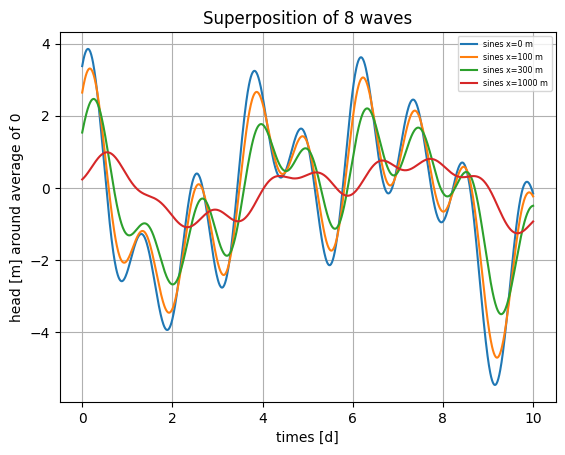

In [104]:
S, kD = 0.001, 600

primes = np.array([1, 3, 5, 7, 9, 11, 17, 19.])
A = (primes.copy()) ** 0.25; np.random.shuffle(A)
omega = 2 * np.pi / (primes.copy() / 2.5); np.random.shuffle(omega)
theta = 2 * np.pi / (primes.copy() / 2.5); np.random.shuffle(theta)

waves = pd.DataFrame()
waves['A'] = A
waves['omega'] = omega
waves['theta'] = theta
waves['a'] = np.sqrt(waves['omega'] * S / (2 * kD))
print(waves)

t = np.linspace(0, 10., 1001)
xs = [0, 100, 300, 1000]

for x in xs:
    s = np.zeros_like(t)
    for i, w in enumerate(waves):
        w = waves.loc[i]
        s += w['A'] * np.exp(-w['a'] * x) * np.sin(w['omega'] * t - w['a'] * x + w['theta'])
    plt.plot(t, s, label=f"sines x={x} m")
    if x == 0: # Store wave at x=0
        sx0 = s.copy()
plt.title("Superposition of 8 waves")
plt.xlabel("times [d]")
plt.ylabel("head [m] around average of 0")
plt.grid()
plt.legend(loc='upper right', fontsize='xx-small')
plt.show()
    

Next, take the wave at x=0 and apply convolution using the function for a sudden change at x=0 as step response:

$$ SR(t) = A \,\mathtt{erfc}\left(\sqrt{\frac{x^2 S}{4 kD t}}\right),\,\,\mathtt{where}\,\,A=1$$

We will plot the previous results (as lines) and the results from the convolution (as dots) on the same plots below. As can be seen the results are the same, except for points farther away, for those points it takes some time before the results are the same. This is because the convolution starts with all heads initially zero, due to which the results gradually climbs to the long-time results when the initial values no longer matter.

In [ ]:
def SR(t, x, S, kD):
    """Return the step response.
    
    Notice that the step response is specific for each type
    of problem (well, river level etc); the block response    
    is not dependent on the type of problem.
    """
    u = x * np.sqrt(S / (4 * kD * t[1:]))
    return np.hstack((0., erfc(u)))

def BR(t, x, S, kD):
    """Return the block response.
    
    Notice that this block response function is independent of
    the type of problem, only the step response is.  
    """
    br = SR(t, x, S, kD)
    br[1:] -= br[:-1]
    return br

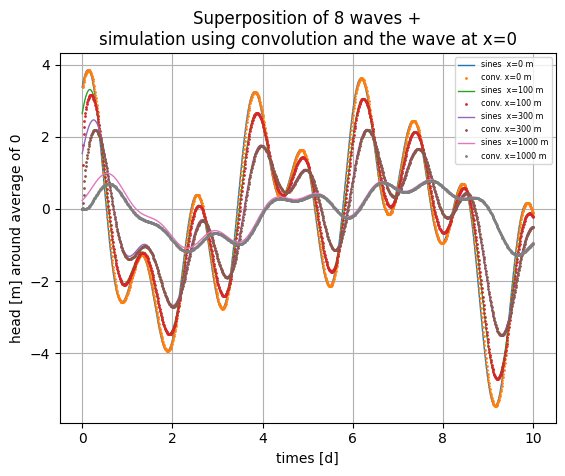

In [108]:
plt.title("Superposition of 8 waves +\nsimulation using convolution and the wave at x=0")
plt.xlabel("times [d]")
plt.ylabel("head [m] around average of 0")

for x in xs:
    s = np.zeros_like(t)
    br = BR(t, x, S, kD)
    for i, w in enumerate(waves):
        w = waves.loc[i]
        s += w['A'] * np.exp(-w['a'] * x) * np.sin(w['omega'] * t - w['a'] * x + w['theta'])
    plt.plot(t, s, '-', lw=1, label=f"sines  x={x} m")
    plt.plot(t, lfilter(br, 1, sx0), '.', ms=2, label=f"conv. x={x} m")
plt.grid()
plt.legend(loc='upper right', fontsize='xx-small')
plt.show()

h = lfilter(br, 1, sx0)

Next we will generate an example of the head in a groundwater basin for which we have the following analytical solution, which describes teh decay of an initial groundwater head of A above its tow boundaries at $x \=- b$.

$$ s(x, t) = A \frac 4 \pi \sum_{j=1}^{\infty}\left[ \frac{-1^{j-1}}{2j - 1}
\cos\left((2j - 1)\left(\frac \pi 2\right)\frac x b\right)
\exp\left(-(2j - 1)^2\left(\frac \pi 2\right)^2\frac{kD}{b^2 S}t\right)\right]$$

Let's first show the behavior of this basin. We'll plot the head as a function of x for a number of half times. The have time is the time in which the head declines by a factor of two. We get the half time from the exponent, while soon after t=0 all higher terms can be neglected.

The argument of the exponent for $j=1$, i.e. the first term is

$$ \frac{\pi}{2}\frac{4 kD t}{b^2 S}=\frac{t}{T}\,\,\mathtt{where}\,\,T=\left(\frac 2 \pi\right)^2 \frac{b^2 S}{kD}$$

and $T_{50\%} = \ln(2) T \approx 0.7 T$.


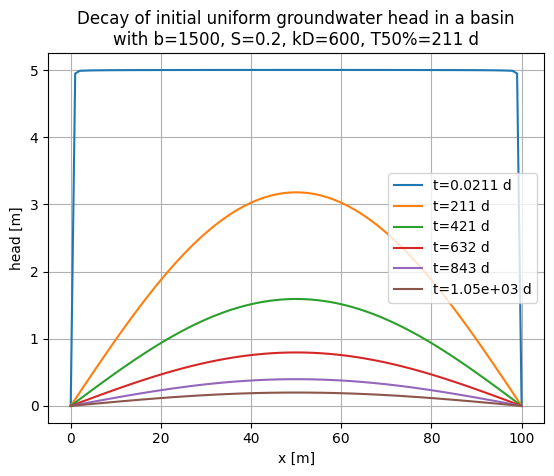

In [140]:
def KvdL(t, x=None, b=None, kD=None, S=None, n=100):
    s = np.zeros_like(x)
    T = b ** 2 * S / kD
    for j in range(1, n):
        j2m1 = 2 * j - 1       
        exp = np.exp(-(j2m1 ** 2) * (np.pi / 2) ** 2 * t / T)
        s += ((-1) ** (j - 1) / j2m1 *
                np.cos(j2m1 * np.pi / 2 * x / b) *
                exp)
    s *= 4 / np.pi / S
    return s

b, S, kD = 1500, 0.2, 600

T50 = np.log(2) * (2 / np.pi) ** 2 * b ** 2 * S / kD

x = np.linspace(-b, b, 101)
ts = T50 * np.array([0.0001, 1, 2, 3, 4, 5])
for t in ts:
    plt.plot(KvdL(t, x=x, b=b, kD=kD, S=S), label=f"t={t:.3g} d")   
plt.title(f"Decay of initial uniform groundwater head in a basin\nwith b={b}, S={S}, kD={kD}, T50%={T50:.0f} d")
plt.xlabel('x [m]')
plt.ylabel('head [m]')
plt.grid()
plt.legend()
plt.show()


So we now have a clear picture of what the solution does.

We can use this solution as a block response due by a sudden recharge of $N$ m, which causes an immediate uniform increase of head equal to $A = N / S_y$ and then the decay of the head to the boundaries starts. Nothing is kept forever, so it's not a step response, the reaction of one recharge puls per day can be seen as a block response.

So for a unit recharge of $N=1$ m, we get the block response of our basin by replacing $A$ by $1 / S_y$ The by choosing a value for $x$ inside the basin, the step response will be for that point.

So let't define the block response first:

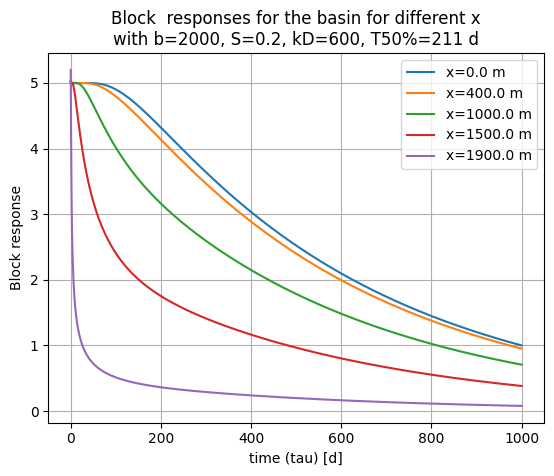

In [191]:
def BR2(t, x=None, b=None, kD=None, S=None, n=20):
    s = np.zeros_like(t)
    T = b ** 2 * S / kD
    for j in range(1, n):
        j2m1 = 2 * j - 1       
        exp = np.exp(-(j2m1 ** 2) * (np.pi / 2) ** 2 * t / T)
        s += ((-1) ** (j - 1) / j2m1 *
                np.cos(j2m1 * np.pi / 2 * x / b) *
                exp)
    s *= 4 / np.pi / S
    return s

b, S, kD = 2000, 0.2, 600
xs = np.array([0, 0.2, 0.5, 0.75, 0.95]) * b
tau = np.linspace(0, 1000, 1001)
for x in xs:
    plt.plot(tau, BR2(tau, x=x, b=b, kD=kD, S=S, n=100), label=f"x={x} m")
plt.title(f"Block  responses for the basin for different x\nwith b={b}, S={S}, kD={kD}, T50%={T50:.0f} d")
plt.xlabel("time (tau) [d]")
plt.ylabel("Block response")
plt.grid()
plt.legend()
plt.show()

You should expect the value to be 5 namely  1 m of recharge divided by a specific yield of $S=0.2$. It seems that the top for x=475 m is a bit too high. This is due to the number n, which is the maximum value of j in the summation. The higher n, the better the approximation is. For points farther from the boundaries fewer terms are necessary. The same is true for later times. For the graph above, n was taken to be 100.

Then we will use it with a time series of recharge from weather station `DeBilt`. From the data we use column `DR`, the estimated recharge in mm/d. The index of the data are timestamps (i.e. np.datetime64 objects).

In [151]:
deBilt = pd.read_csv("deBilt.csv", header=0, parse_dates=True, index_col=0)
deBilt

DR    RH  EV24
1960-01-01  3.8   2.5   0.1
1960-01-02  1.3   0.6   0.2
1960-01-03  0.3   0.1   0.3
1960-01-04  4.5   0.9   0.1
1960-01-05  7.3   3.9   0.0
...         ...   ...   ...
2024-07-11  0.0   0.0   3.0
2024-07-12  7.3  25.3   0.9
2024-07-13  2.8   2.9   2.0
2024-07-14  0.0   0.0   4.1
2024-07-15  2.2   2.4   4.1

[23573 rows x 3 columns]

Show the recharge data (only for a small time span, or otherwise we can't see the details).

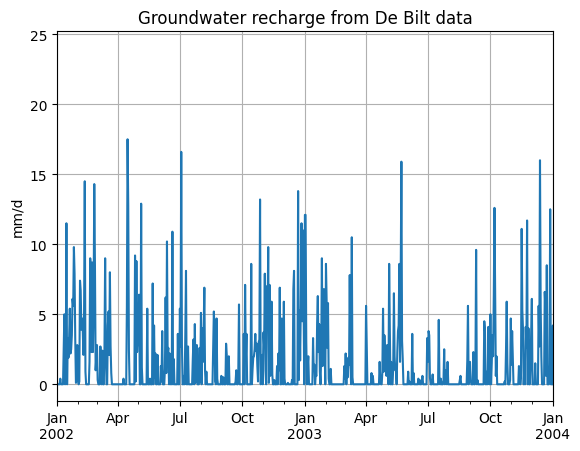

In [184]:
fig, ax = plt.subplots()
deBilt['DR'].plot(ax=ax)
# You can change dates below as you like to select a time span.
ax.set_xlim(np.datetime64("2002-01-01"), np.datetime64("2004-01-01"))
plt.title("Groundwater recharge from De Bilt data")
plt.ylabel("mm/d")
plt.grid()
plt.show()

Now we do the convolution to see how the groundwater develops in our basin due to the actual recharge.

recharge =  [0.0038 0.0013 0.0003 ... 0.0028 0.     0.0022]  m/d
t        =  [0.0000e+00 1.0000e+00 2.0000e+00 ... 2.3570e+04 2.3571e+04 2.3572e+04]  d


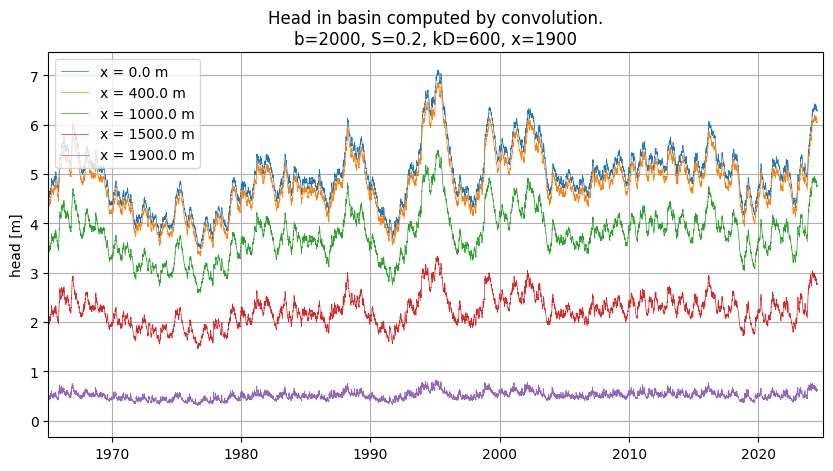

In [195]:
recharge = deBilt['DR'].values / 1000. # m/d
t = np.asarray((deBilt.index - deBilt.index[0]) / np.timedelta64(1, 'D'))

print('recharge = ', recharge, ' m/d')
print('t        = ', t, ' d')

b, S, kD = 2000, 0.2, 600
xs = np.array([0, 0.2, 0.5, 0.75, 0.95]) * b

fig, ax = plt.subplots(figsize=(10, 5))
tau = np.arange(5 * T50)
for x in xs:
    br = BR2(tau, x=x, b=b, kD=kD, S=S, n=100)    
    ax.plot(deBilt.index, lfilter(br,1, recharge), lw=0.5, label=f'x = {x} m')

ax.set_xlim(np.datetime64("1965-02-02"), np.datetime64("2025-01-01"))
ax.set_title(f"Head in basin computed by convolution.\nb={b}, S={S}, kD={kD}, x={x:.0f}")
ax.set_ylabel("head [m]")
ax.grid(True)
ax.legend()


As can be seen the head in the center of the basin (at $x=0$) becomes highest and declines near the edges of the basin at $x \=- 2000$ m. All lines have a similar pattern because the recharge is the same for each line, i.e. for each point $x$. The number of data points is about 23000 (number of days in the file `deBilt.csv`) 

Next we take a Theis well as an example. The Theis drawdown formula is clearly a step response (when we take $Q=1$ m3/d). Before we define it, let's generate some time-varying extraction data. We do this below from random numbers. In a practical case, these data should come from a database at the water company or so.

Text(0, 0.5, 'Q [m3/d]')

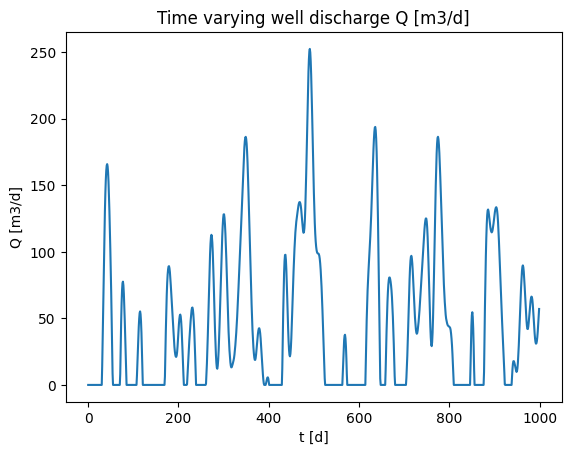

In [202]:
def Qseries(Q0, n=1000, N=10):
    """Return a time series to use as input extractions.
    
    Parameters
    ----------
    Q0: float
        factor to set the maximum extraction.
    n: int
        the length of the extraction series    
    """
    Q = np.random.random(n) - 0.5

    for iz in range(4):
        Q = lfilter(np.ones(N)/ N, 1, Q)   # + lfilter(np.ones(N) / N, 1, Q[::-1])
    Q[Q < 0] = 0.
    Q *= Q0
    return Q

Q = Qseries(1200.)
plt.plot(Q)
plt.title("Time varying well discharge Q [m3/d]")
plt.xlabel("t [d]")
plt.ylabel("Q [m3/d]")

Next step is to define the step response and the block response for the Theis well.

In [204]:
def SRw(tau, r, kD, S):
    """Return step response for the Theis well."""
    u = r ** 2 * S / (4 * kD * tau[1:])
    sr = 1 / (4 * np.pi * kD) * exp1(u) # For Theis well exp1(u) = W(u)
    return np.hstack((0, sr))

def BRw(tau, r, kD, S):
    """Return the block response."""
    br = SRw(tau, r, kD, S)
    br[1:] -= br[:-1]
    return br

Then apply the block response to simulate the drawdown caused by the Theis well if given the time-varying extraction data.

Normally one limits the length of the block response (length of tau) to a value after which the response values have become practically zero. However, the Theis well does not have a final steady state. Therefore, we take the length of the block response equally long at the entire period of pumping. Longer is not necessary, as the heads before pumping started are all assumed to be zero.

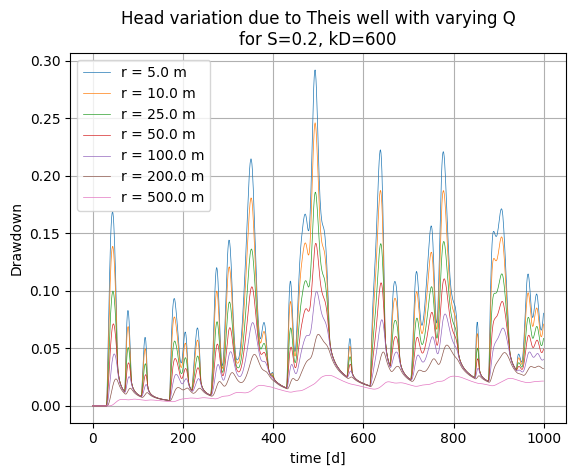

In [205]:
time = np.arange(len(Q)) # dates
tau  = np.arange(len(Q)) # days since start of response, as long as 

S, kD = 0.2, 600
rs = [5., 10., 25., 50., 100., 200., 500.] # distances from the well

for r in rs:
    br = BRw(tau, r, kD, S)
    s = lfilter(br, 1, Q)
    plt.plot(time, s, lw=0.5, label=f"r = {r} m")
    
plt.title(f"Head variation due to Theis well with varying Q\nfor S={S}, kD={kD}")
plt.xlabel('time [d]')
plt.ylabel("Drawdown")
plt.grid()
plt.legend()
plt.show()

This concludes the examples with convolution.

-----